<a href="https://colab.research.google.com/github/khushishelat/GenderBiasSportsJournalism/blob/Khushi/TopicModellingWithChangedData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we're going to re-do topic modelling for our project with a focus on examining how the topic modelling results change as a result of the different datasets we have created:


*   Questions dataframe, cleaned
*   Questions dataframe, cleaned with removed gender pronouns
*   Commentaries dataframe, cleaned
*   Commentaries dataframe, cleaned with removed gender pronouns



In [1]:
import pandas as pd

In [7]:
import re, nltk, spacy, string

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# import pyLDAvis
# import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


In [2]:
# read in datasets
commentaries_df_removed_gender = pd.read_csv('/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Data/tennis_data/commentaries_df_removed_gender.csv')
commentaries_df_with_gender = pd.read_csv('/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Data/tennis_data/commentaries_df_with_gender.csv')

questions_df_removed_gender = pd.read_csv('/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Data/tennis_data/questions_df_removed_gender.csv')
questions_df_with_gender = pd.read_csv('/content/drive/MyDrive/CIS 5300 NLP Project/Project Notebook/Data/tennis_data/questions_df_with_gender.csv')

# Questions Dataframe Topic Modeling

## Gender Removed

### Both together

In [21]:
vectorizer_questions_no_gender = CountVectorizer(analyzer='word',
                             min_df=3,                        # minimum required occurences of a word
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000,             # max number of unique words. Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
                            )

data_vectorized_questions_no_gender = vectorizer_questions_no_gender.fit_transform(questions_df_removed_gender['questions'])

lda_model_questions_no_gender = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output_questions_no_gender = lda_model_questions_no_gender.fit_transform(data_vectorized_questions_no_gender)

In [22]:
# Function to display top words for each topic
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d" % (topic_idx)] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [23]:
# Get feature names (words) from the vectorizer
feature_names_questions_no_gender = vectorizer_questions_no_gender.get_feature_names_out()

# Set the number of top words you want to display for each topic
no_top_words = 20

# Display the top words for each topic
top_words_df_questions_no_gender = display_topics(lda_model_questions_no_gender, feature_names_questions_no_gender, no_top_words)

top_words_df_questions_no_gender

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,lot,play,playing,match,bit,court,way,tennis,set,played,great,saying,like,win,good,make,game,serve,coming,talk
1,players,point,player,like,little,different,going,end,year,tournament,mean,tournaments,feel,said,got,big,hard,difficult,grass,feeling
2,things,better,like,cup,tell,maybe,look,able,second,years,wimbledon,trying,slam,matches,pretty,day,times,today,mentioned,lost
3,tough,think,tour,mind,couple,round,think,happened,time,year,moment,record,grand,open,best,today,went,crowd,doubles,sets
4,quite,want,court,points,talking,season,final,new,long,come,year,aggressive,really,week,right,career,clay,away,surface,especially
5,like,level,feel,going,happy,know,getting,pressure,break,ago,yesterday,person,beat,going,confidence,start,looking,hit,court,left
6,kind,sort,think,close,days,change,tomorrow,terms,think,think,world,chinese,looked,thoughts,winning,difference,courts,surprised,people,tired
7,working,thing,draw,feel,women,opponent,games,said,question,today,felt,consider,past,thought,feel,think,net,try,watch,asked
8,think,going,help,seen,tennis,like,actually,work,coach,compared,talked,speaking,night,think,far,conditions,forward,early,feel,return
9,problems,weeks,started,shots,like,playing,tonight,injury,thinking,like,given,seeing,need,time,today,slams,going,wanted,tournament,tiebreak


In [24]:
from scipy.stats import ks_2samp

# Create a DataFrame to store the p-values for each topic
ks_test_results = pd.DataFrame(index=range(lda_model_questions_no_gender.n_components), columns=['p_value'])

# Extract the topic proportions for each document
topic_proportions = pd.DataFrame(lda_output_questions_no_gender, columns=[f'Topic {i}' for i in range(lda_model_questions_no_gender.n_components)])

# Add the 'gender' column from the original dataframe to topic_proportions
topic_proportions['gender'] = questions_df_removed_gender['gender'].values

# Perform the KS test for each topic
for topic_idx in range(lda_model_questions_no_gender.n_components):
    topic_values_male = topic_proportions.loc[topic_proportions['gender'] == 'M', f'Topic {topic_idx}']
    topic_values_female = topic_proportions.loc[topic_proportions['gender'] == 'F', f'Topic {topic_idx}']

    # Perform the KS test
    ks_statistic, p_value = ks_2samp(topic_values_male, topic_values_female)

    # Store the p-value in the results DataFrame
    ks_test_results.at[topic_idx, 'p_value'] = p_value

# Display the results
print(ks_test_results)


     p_value
0        0.0
1   0.016133
2   0.088798
3    0.00748
4   0.000094
5        0.0
6   0.000424
7   0.123977
8   0.002325
9   0.037914
10  0.001304
11   0.10025
12       0.0
13  0.081002
14  0.001127
15  0.001305
16       0.0
17  0.055021
18  0.005182
19  0.023967


Topics that are significant differences:


*   Topic 0
*   Topic 1
*   Topic 3
*   Topic 4
*   Topic 5
*   Topic 6
*   Topic 8
*   Topic 9
*   Topic 10
*   Topic 12
*   Topic 14
*   Topic 15
*   Topic 16
*   Topic 18
*   Topic 19




### Separate Genders

In [25]:
# create the split gender datasets
questions_df_ng_female = questions_df_removed_gender[questions_df_removed_gender['gender'] == 'F']
questions_df_ng_male = questions_df_removed_gender[questions_df_removed_gender['gender'] == 'M']

In [26]:
# do the female LDA model on gender removed
vectorizer_questions_ng_female = CountVectorizer(analyzer='word',
                             min_df=3,                        # minimum required occurences of a word
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000,             # max number of unique words. Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
                            )

data_vectorized_questions_ng_female = vectorizer_questions_ng_female.fit_transform(questions_df_ng_female['questions'])

lda_model_questions_ng_female = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output_questions_ng_female = lda_model_questions_ng_female.fit_transform(data_vectorized_questions_ng_female)


In [27]:
# do the male LDA model on gender removed
vectorizer_questions_ng_male = CountVectorizer(analyzer='word',
                             min_df=3,                        # minimum required occurences of a word
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000,             # max number of unique words. Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
                            )

data_vectorized_questions_ng_male = vectorizer_questions_ng_male.fit_transform(questions_df_ng_male['questions'])

lda_model_questions_ng_male = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output_questions_ng_male = lda_model_questions_ng_male.fit_transform(data_vectorized_questions_ng_male)

In [28]:
def get_top_words(lda_model, vectorizer, n_words=20):
    words = vectorizer.get_feature_names_out()
    topics = []
    top_words = []
    frequencies = []

    for topic_idx, topic in enumerate(lda_model.components_):
        top_word_indices = topic.argsort()[:-n_words - 1:-1]
        topic_words = [words[idx] for idx in top_word_indices]
        topic_frequencies = topic[top_word_indices]

        topics.extend([f"Topic {topic_idx + 1}"] * n_words)
        top_words.extend(topic_words)
        frequencies.extend(topic_frequencies)

    df = pd.DataFrame({'Topic': topics, 'Word': top_words, 'Frequency': frequencies})
    return df

In [29]:
topwords_df_ng_male = get_top_words(lda_model_questions_ng_male, vectorizer_questions_ng_male, n_words=20)

In [30]:
topwords_df_ng_female = get_top_words(lda_model_questions_ng_female, vectorizer_questions_ng_female, n_words=20)

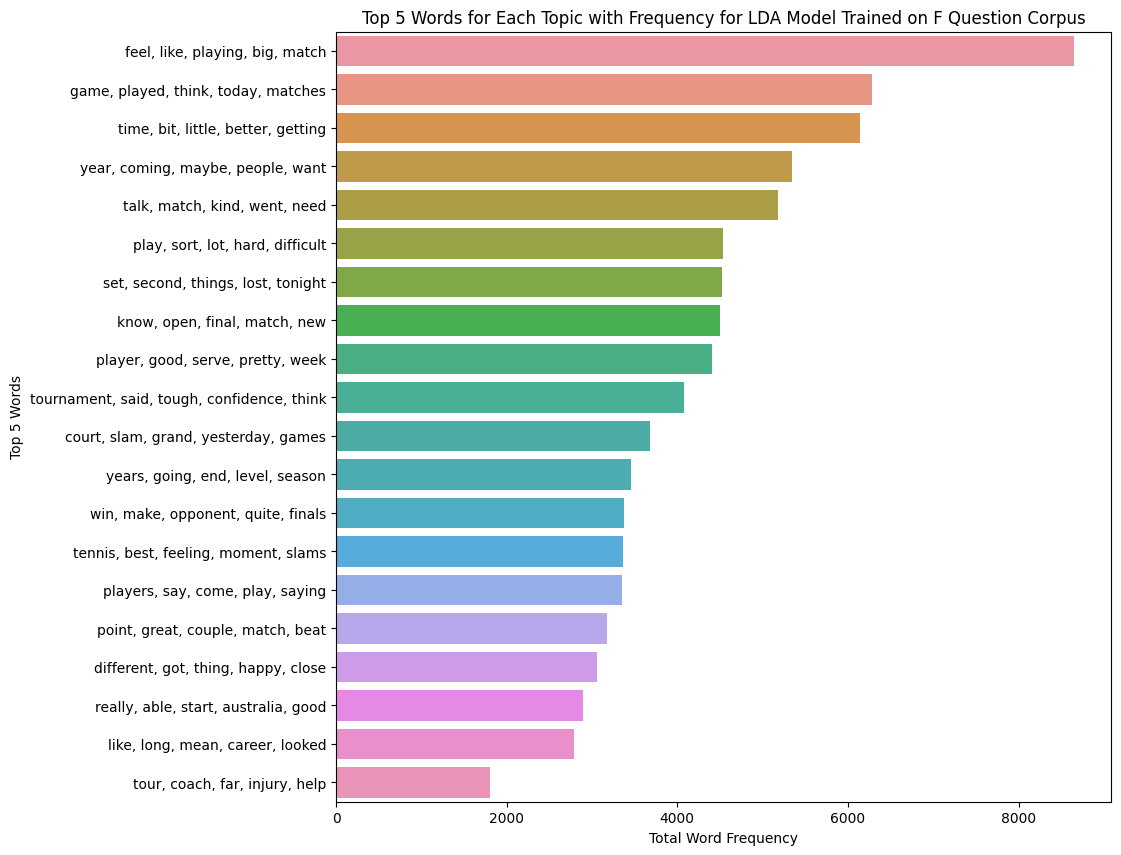

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the top 5 words for each topic
topwords_df_ng_female_by_topic = topwords_df_ng_female.groupby('Topic').apply(lambda x: x.nlargest(5, 'Frequency')).reset_index(drop=True)

# Group by topic and aggregate the top 5 words into a list and sum the frequencies
grouped_df_female = topwords_df_ng_female_by_topic.groupby('Topic').agg({'Word': lambda x: list(x), 'Frequency': 'sum'}).reset_index()

# Convert the 'word' column to strings
grouped_df_female['Word'] = grouped_df_female['Word'].apply(lambda x: ', '.join(x))

grouped_df_female = grouped_df_female.sort_values(by='Frequency', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Word', data=grouped_df_female, dodge=True)

# Set labels and title
plt.xlabel('Total Word Frequency')
plt.ylabel('Top 5 Words')
plt.title('Top 5 Words for Each Topic with Frequency for LDA Model Trained on F Question Corpus')

# Show the plot
plt.show()


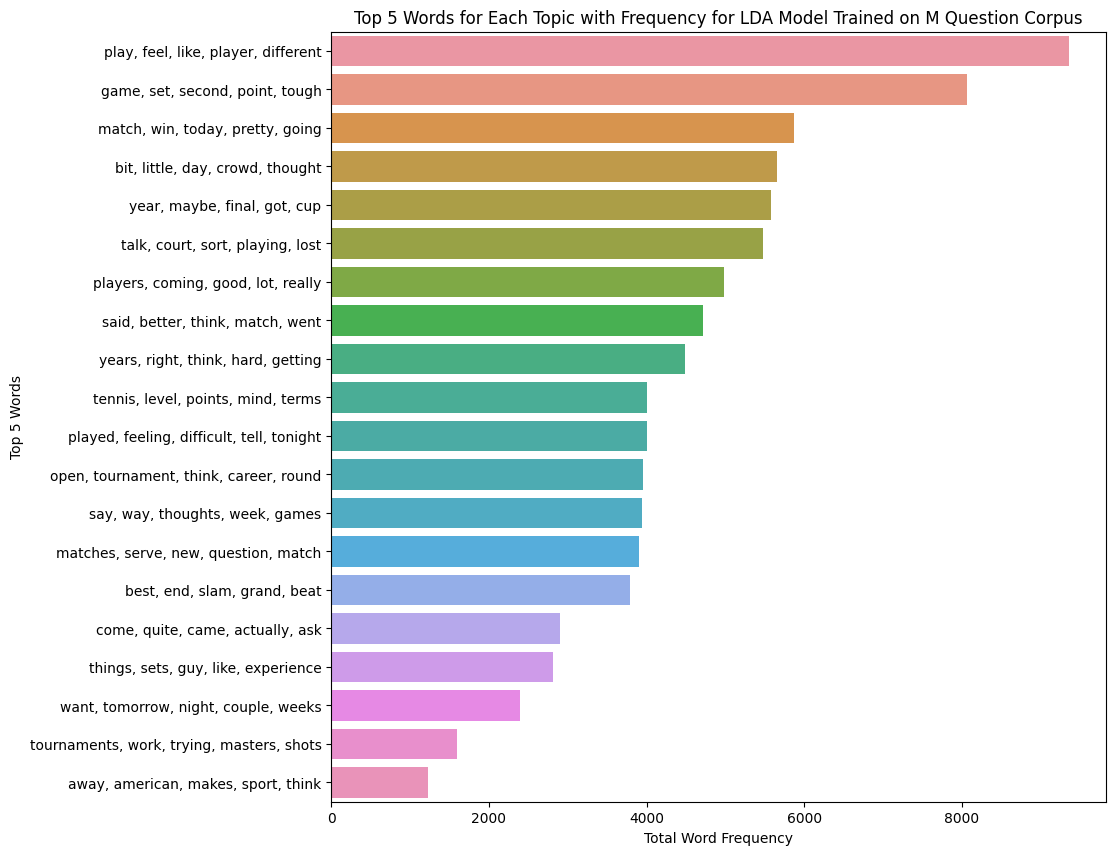

In [32]:
# Extract the top 5 words for each topic
topwords_df_ng_male_by_topic = topwords_df_ng_male.groupby('Topic').apply(lambda x: x.nlargest(5, 'Frequency')).reset_index(drop=True)

# Group by topic and aggregate the top 5 words into a list and sum the frequencies
grouped_df_male = topwords_df_ng_male_by_topic.groupby('Topic').agg({'Word': lambda x: list(x), 'Frequency': 'sum'}).reset_index()

# Convert the 'word' column to strings
grouped_df_male['Word'] = grouped_df_male['Word'].apply(lambda x: ', '.join(x))

grouped_df_male = grouped_df_male.sort_values(by='Frequency', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Word', data=grouped_df_male, dodge=True)

# Set labels and title
plt.xlabel('Total Word Frequency')
plt.ylabel('Top 5 Words')
plt.title('Top 5 Words for Each Topic with Frequency for LDA Model Trained on M Question Corpus')

# Show the plot
plt.show()

### Attempt guided LDA

In [17]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

# Example data:
questions_data = questions_df_removed_gender['questions'].tolist()

# Create a CountVectorizer
vectorizer = CountVectorizer(analyzer='word',
                             min_df=3,
                             stop_words='english',
                             lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',
                             max_features=5000)

# Fit and transform the text data to obtain a document-term matrix
data_vectorized = vectorizer.fit_transform(questions_data)

# Seed words for each topic
seed_words = [
    ['appearance', 'outfit', 'attire', 'style', 'dress'],
    ['appearance', 'sportsmanship', 'tennis', 'lingo', 'style'],
    ['athleticism', 'performance', 'strength', 'agility'],
    ['challenges', 'weaknesses', 'limitations', 'struggles'],
    ['skills', 'achievements', 'successes', 'accomplishments', 'highlights'],
    ['mistakes', 'losses', 'failures', 'setbacks', 'challenges'],
    ['family', 'support', 'relationships', 'personal', 'life'],
    ['mentality', 'emotional', 'strengths', 'focus'],
    ['mental', 'fragility', 'weaknesses', 'pressure'],
    ['humor', 'fun', 'lightheartedness', 'jokes', 'entertainment']
]

# Create a new LDA model
lda_model = LatentDirichletAllocation(n_components=20, learning_method='online', random_state=0, n_jobs=-1)

# Fit the model with the data and seed words
lda_model.fit(data_vectorized)

# Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d" % (topic_idx)] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

# Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Set the number of top words you want to display for each topic
no_top_words = 10

# Display the top words for each topic
top_words_df = display_topics(lda_model, feature_names, no_top_words)
print(top_words_df)


    Topic 0 Topic 1  Topic 2 Topic 3  Topic 4    Topic 5   Topic 6   Topic 7  \
0       lot    play  playing   match      bit      court       way    tennis   
1   players   point   player    like   little  different     going       end   
2    things  better     like     cup     tell      maybe      look      able   
3     tough   think     tour    mind   couple      round     think  happened   
4     quite    want    court  points  talking     season     final       new   
5      like   level     feel   going    happy       know   getting  pressure   
6      kind    sort    think   close     days     change  tomorrow     terms   
7   working   thing     draw    feel    women   opponent     games      said   
8     think   going     help    seen   tennis       like  actually      work   
9  problems   weeks  started   shots     like    playing   tonight    injury   

    Topic 8     Topic 9   Topic 10     Topic 11 Topic 12  Topic 13  \
0       set      played      great       saying  

In [18]:

# Predict the topic distribution for each document
lda_predictions = lda_model.transform(data_vectorized)

# Add the topic distribution as columns to your DataFrame
for i in range(lda_model.n_components):
    questions_df_removed_gender[f'Topic {i}'] = lda_predictions[:, i]

# Group by gender and calculate the mean topic distribution for each group
topic_means_by_gender = questions_df_removed_gender.groupby('gender').mean().filter(like='Topic')

# Display the mean topic distribution for each gender
print(topic_means_by_gender)


         Topic 0   Topic 1   Topic 2   Topic 3   Topic 4   Topic 5   Topic 6  \
gender                                                                         
F       0.049937  0.058172  0.050576  0.052407  0.053605  0.050447  0.052077   
M       0.045331  0.060020  0.051129  0.053068  0.051803  0.054230  0.050631   

        Topic 7   Topic 8   Topic 9  Topic 10  Topic 11  Topic 12  Topic 13  \
gender                                                                        
F       0.06093  0.056216  0.059227  0.049632  0.027989  0.052572  0.060671   
M       0.05975  0.055392  0.058588  0.051265  0.028845  0.047422  0.061474   

        Topic 14  Topic 15  Topic 16  Topic 17  Topic 18  Topic 19  
gender                                                              
F       0.053921  0.050088  0.043491  0.042994  0.039795  0.035254  
M       0.054312  0.049565  0.047438  0.044374  0.039615  0.035747  


<ipython-input-18-16ce204a8ef5>:11: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



# Commentaries Dataframe Exploration

## Gender Removed

### Both Together (seed/guided LDA)

In [34]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

# Example data:
commentaries_data = commentaries_df_removed_gender['commentary'].tolist()

# Create a CountVectorizer
vectorizer = CountVectorizer(analyzer='word',
                             min_df=3,
                             stop_words='english',
                             lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',
                             max_features=5000)

# Fit and transform the text data to obtain a document-term matrix
data_vectorized = vectorizer.fit_transform(commentaries_data)

# Create a new LDA model
lda_model = LatentDirichletAllocation(n_components=40, learning_method='online', random_state=0, n_jobs=-1)

# Fit the model with the data and seed words
lda_model.fit(data_vectorized)

# Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d" % (topic_idx)] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

# Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Set the number of top words you want to display for each topic
no_top_words = 10

# Display the top words for each topic
top_words_df = display_topics(lda_model, feature_names, no_top_words)
print(top_words_df)


      Topic 0       Topic 1  Topic 2      Topic 3        Topic 4      Topic 5  \
0     finally      teenager    break     forehand         regain     responds   
1      german      somewhat   tennis        deuce  groundstrokes        games   
2  resistance          dead     game         gets      remainder         wide   
3      apiece         reach      tie  comfortably         mishit      running   
4        life          deep    great     misfires          array          ace   
5      manage        engage    serve         took        secures        serve   
6    tiebreak          dips    races      extends          court     finishes   
7       bagel  disheartened     good       famous          extra      gifting   
8   ukrainian          neck  passing        swiss           lead  competition   
9    suddenly          said     time       seeing          plays       drifts   

    Topic 6   Topic 7   Topic 8      Topic 9  ...     Topic 30      Topic 31  \
0  momentum     serve     ho

In [39]:
# Predict the topic distribution for each document
lda_predictions = lda_model.transform(data_vectorized)

# Add the topic distribution as columns to your DataFrame
for i in range(lda_model.n_components):
    commentaries_df_removed_gender[f'Topic {i}'] = lda_predictions[:, i]

# Group by gender and calculate the mean topic distribution for each group
topic_means_by_gender = commentaries_df_removed_gender.groupby('gender').mean().filter(like='Topic')

# Display the mean topic distribution for each gender
print(topic_means_by_gender)

         Topic 0   Topic 1   Topic 2   Topic 3   Topic 4   Topic 5   Topic 6  \
gender                                                                         
F       0.007376  0.001928  0.043992  0.001928  0.002506  0.001928  0.003309   
M       0.007456  0.001873  0.040225  0.001873  0.002833  0.001873  0.003193   

         Topic 7   Topic 8   Topic 9  ...  Topic 30  Topic 31  Topic 32  \
gender                                ...                                 
F       0.057454  0.026664  0.101187  ...  0.002601  0.008958  0.214464   
M       0.054425  0.030492  0.120750  ...  0.002764  0.007985  0.186060   

        Topic 33  Topic 34  Topic 35  Topic 36  Topic 37  Topic 38  Topic 39  
gender                                                                        
F       0.002975  0.001928  0.022116  0.037329  0.001928  0.008281  0.002777  
M       0.003183  0.001873  0.019129  0.037480  0.001873  0.008471  0.002961  

[2 rows x 40 columns]


<ipython-input-39-395c41644e2e>:9: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [40]:
from scipy.stats import mannwhitneyu

# Extract topic columns for each gender
topics_f = commentaries_df_removed_gender[commentaries_df_removed_gender['gender'] == 'F'].filter(like='Topic')
topics_m = commentaries_df_removed_gender[commentaries_df_removed_gender['gender'] == 'M'].filter(like='Topic')

# Perform Mann-Whitney U test for each topic
p_values = []
for i in range(lda_model.n_components):
    _, p_value = mannwhitneyu(topics_f[f'Topic {i}'], topics_m[f'Topic {i}'])
    p_values.append(p_value)

# Display p-values for each topic
print("Mann-Whitney U test p-values:")
for i, p_value in enumerate(p_values):
    print(f'Topic {i}: {p_value}')


Mann-Whitney U test p-values:
Topic 0: 0.07720960101284034
Topic 1: 0.5200561335293998
Topic 2: 0.0454524762776321
Topic 3: 0.5200561335293998
Topic 4: 0.28425437254096664
Topic 5: 0.5200561335293998
Topic 6: 0.39290092865880755
Topic 7: 0.006805496435175256
Topic 8: 0.009703220031519457
Topic 9: 3.610513599747159e-08
Topic 10: 0.06137790928696524
Topic 11: 0.5835708630064791
Topic 12: 0.00010036007258414301
Topic 13: 0.11345910173535029
Topic 14: 0.005312456789843081
Topic 15: 0.026718378097340748
Topic 16: 0.024928409715792313
Topic 17: 0.5041369133862577
Topic 18: 0.601905266634041
Topic 19: 0.02428215772006462
Topic 20: 0.14067175601930795
Topic 21: 0.5200561335293998
Topic 22: 0.0018496734176190912
Topic 23: 0.20144399221360898
Topic 24: 0.00031364235537116375
Topic 25: 0.0010842114629173055
Topic 26: 4.7600990872695075e-07
Topic 27: 0.010988088269774099
Topic 28: 0.4979599890285684
Topic 29: 0.13130888557576073
Topic 30: 0.1843375748631868
Topic 31: 0.8148030983416954
Topic 32: 0

In [42]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import mannwhitneyu
import pandas as pd
import numpy as np

# Example data:
commentaries_data = commentaries_df_removed_gender['commentary'].tolist()

# Assuming you already have a trained LDA model named lda_model

# Create a CountVectorizer (use the same one you used for training)
vectorizer = CountVectorizer(analyzer='word',
                             min_df=3,
                             stop_words='english',
                             lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',
                             max_features=5000)

# Fit and transform the text data to obtain a document-term matrix
data_vectorized = vectorizer.fit_transform(commentaries_data)

# Add topic distribution columns to your DataFrame
lda_predictions = lda_model.transform(data_vectorized)

for i in range(lda_model.n_components):
    commentaries_df_removed_gender[f'Topic {i}'] = lda_predictions[:, i]

# Extract topic columns for each gender
topics_f = commentaries_df_removed_gender[commentaries_df_removed_gender['gender'] == 'F'].filter(like='Topic')
topics_m = commentaries_df_removed_gender[commentaries_df_removed_gender['gender'] == 'M'].filter(like='Topic')

# Perform Mann-Whitney U test for each topic
significant_topics = []
for i in range(lda_model.n_components):
    _, p_value = mannwhitneyu(topics_f[f'Topic {i}'], topics_m[f'Topic {i}'])

    # Check if the topic is significant (adjust significance level if needed)
    if p_value < 0.05:
        significant_topics.append(f'Topic {i}')

# Display top words and percentage for significant topics
for topic_name in significant_topics:
    # Get the top words for each topic
    topic_idx = int(topic_name.split()[-1])
    top_words_idx = lda_model.components_[topic_idx].argsort()[:-no_top_words - 1:-1]
    top_words = [vectorizer.get_feature_names_out()[idx] for idx in top_words_idx]

    # Calculate the percentage of topics in male and female corpora
    topic_percentage_m = topics_m[f'Topic {topic_idx}'].mean() * 100
    topic_percentage_f = topics_f[f'Topic {topic_idx}'].mean() * 100

    print(f"{topic_name} - Top Words: {', '.join(top_words)}")
    print(f"Percentage in Male Corpus: {topic_percentage_m:.2f}%")
    print(f"Percentage in Female Corpus: {topic_percentage_f:.2f}%\n")


Topic 2 - Top Words: break, tennis, game, tie, great, serve, races, good, passing, time
Percentage in Male Corpus: 4.02%
Percentage in Female Corpus: 4.40%

Topic 7 - Top Words: serve, hold, game, easy, make, gets, away, quite, getting, pressure
Percentage in Male Corpus: 5.44%
Percentage in Female Corpus: 5.75%

Topic 8 - Top Words: holds, love, serve, playing, ahead, brit, man, nerve, probably, breaking
Percentage in Male Corpus: 3.05%
Percentage in Female Corpus: 2.67%

Topic 9 - Top Words: set, game, serve, service, hold, second, match, love, ace, comfortable
Percentage in Male Corpus: 12.07%
Percentage in Female Corpus: 10.12%

Topic 12 - Top Words: serb, ends, board, strikes, hanging, wrapping, produced, credit, dumping, spells
Percentage in Male Corpus: 0.90%
Percentage in Female Corpus: 0.66%

Topic 14 - Top Words: final, swiss, place, bit, court, centre, unreturnable, energy, quarter, longest
Percentage in Male Corpus: 1.21%
Percentage in Female Corpus: 0.95%

Topic 15 - Top W

### Separated

In [44]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Assuming you have a DataFrame named commentaries_df_removed_gender
# with 'gender' column and a column for text data, e.g., 'commentary_text'

# Separate data for female and male corpora
commentaries_data_f = commentaries_df_removed_gender[commentaries_df_removed_gender['gender'] == 'F']['commentary'].tolist()
commentaries_data_m = commentaries_df_removed_gender[commentaries_df_removed_gender['gender'] == 'M']['commentary'].tolist()

# Create a CountVectorizer for female corpus
vectorizer_f = CountVectorizer(analyzer='word',
                               min_df=3,
                               stop_words='english',
                               lowercase=True,
                               token_pattern='[a-zA-Z0-9]{3,}',
                               max_features=5000)

# Fit and transform the text data for female corpus
data_vectorized_f = vectorizer_f.fit_transform(commentaries_data_f)

# Create a new LDA model for female corpus
lda_model_f = LatentDirichletAllocation(n_components=40, learning_method='online', random_state=0, n_jobs=-1)

# Fit the model with the data
lda_model_f.fit(data_vectorized_f)

# Display the top words for each topic in the female corpus
top_words_df_f = display_topics(lda_model_f, vectorizer_f.get_feature_names_out(), no_top_words)
print("Top Words for Female Corpus:")
print(top_words_df_f)

# Create a CountVectorizer for male corpus
vectorizer_m = CountVectorizer(analyzer='word',
                               min_df=3,
                               stop_words='english',
                               lowercase=True,
                               token_pattern='[a-zA-Z0-9]{3,}',
                               max_features=5000)

# Fit and transform the text data for male corpus
data_vectorized_m = vectorizer_m.fit_transform(commentaries_data_m)

# Create a new LDA model for male corpus
lda_model_m = LatentDirichletAllocation(n_components=40, learning_method='online', random_state=0, n_jobs=-1)

# Fit the model with the data
lda_model_m.fit(data_vectorized_m)

# Display the top words for each topic in the male corpus
top_words_df_m = display_topics(lda_model_m, vectorizer_m.get_feature_names_out(), no_top_words)
print("\nTop Words for Male Corpus:")
print(top_words_df_m)


Top Words for Female Corpus:
      Topic 0      Topic 1     Topic 2   Topic 3     Topic 4    Topic 5  \
0       swiss     champion  successful    making      hardly       hard   
1   crunching        right    occasion    taking       needs    wilting   
2  prevailing  comfortably      points    injury     control    believe   
3       ready        wrong    backhand  movement  completely     breaks   
4   excellent      respond        ends    senses      losing  treatment   
5        seal    defending         row     happy       serve    screams   
6        pays       umpire         run    intact      danger      turns   
7       crack        power  aggressive    escape        lost      champ   
8      effect     response       seals      test       point     barely   
9      gifted         deal    spaniard     reels         way    display   

     Topic 6       Topic 7   Topic 8     Topic 9  ... Topic 30    Topic 31  \
0    quickly        firing      game  belarusian  ...     zone     

In [45]:
topwords_df_commentaries_male = get_top_words(lda_model_m, vectorizer_m, n_words=20)

In [46]:
topwords_df_commentaries_female = get_top_words(lda_model_f, vectorizer_f, n_words=20)

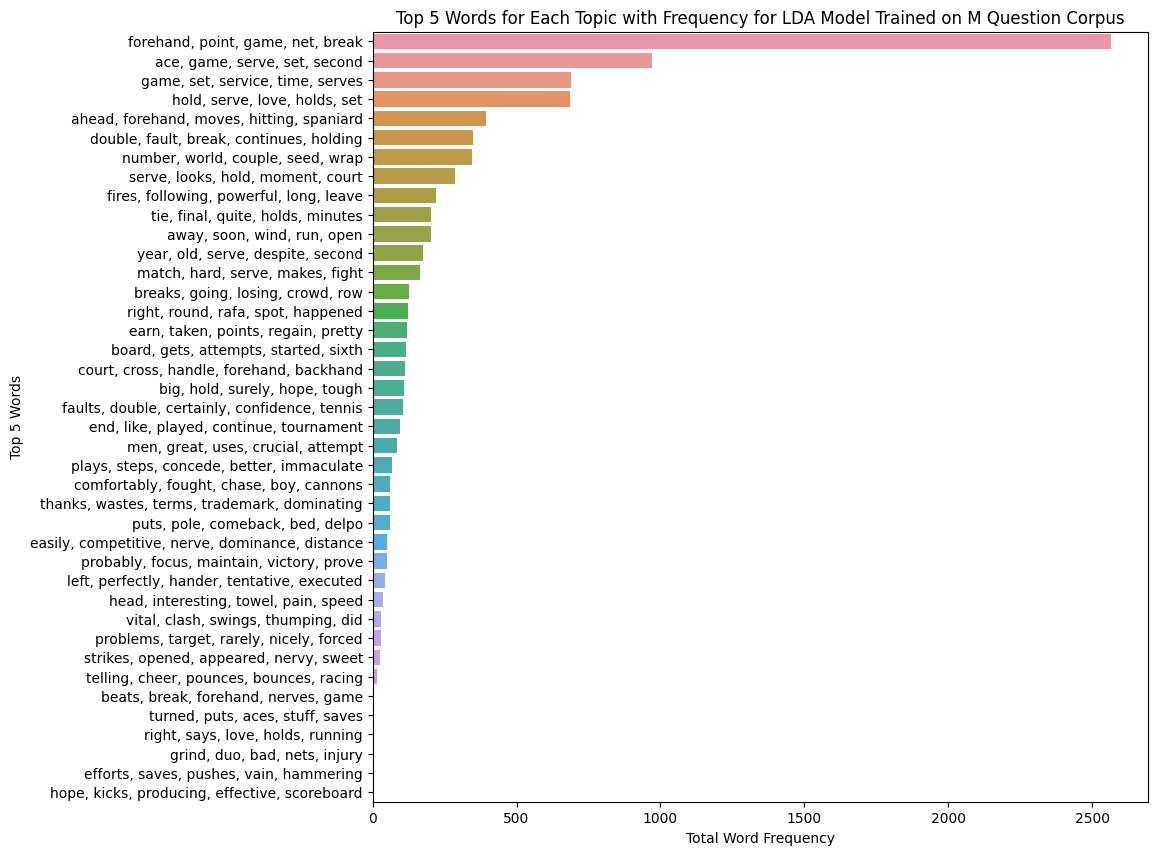

In [47]:
# Extract the top 5 words for each topic
topwords_df_commentaries_male_bytopic = topwords_df_commentaries_male.groupby('Topic').apply(lambda x: x.nlargest(5, 'Frequency')).reset_index(drop=True)

# Group by topic and aggregate the top 5 words into a list and sum the frequencies
grouped_df_male = topwords_df_commentaries_male_bytopic.groupby('Topic').agg({'Word': lambda x: list(x), 'Frequency': 'sum'}).reset_index()

# Convert the 'word' column to strings
grouped_df_male['Word'] = grouped_df_male['Word'].apply(lambda x: ', '.join(x))

grouped_df_male = grouped_df_male.sort_values(by='Frequency', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Word', data=grouped_df_male, dodge=True)

# Set labels and title
plt.xlabel('Total Word Frequency')
plt.ylabel('Top 5 Words')
plt.title('Top 5 Words for Each Topic with Frequency for LDA Model Trained on M Question Corpus')

# Show the plot
plt.show()

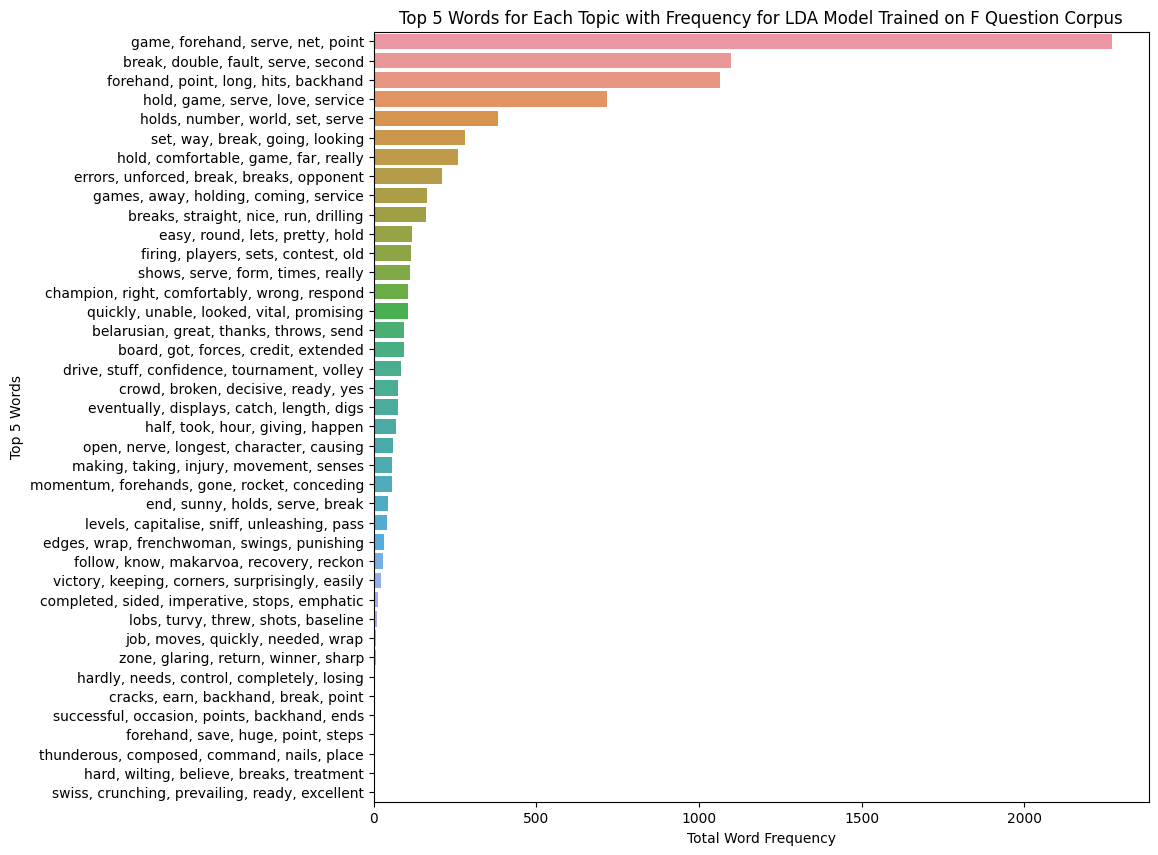

In [48]:
# Extract the top 5 words for each topic
topwords_df_commentaries_female_bytopic = topwords_df_commentaries_female.groupby('Topic').apply(lambda x: x.nlargest(5, 'Frequency')).reset_index(drop=True)

# Group by topic and aggregate the top 5 words into a list and sum the frequencies
grouped_df_female = topwords_df_commentaries_female_bytopic.groupby('Topic').agg({'Word': lambda x: list(x), 'Frequency': 'sum'}).reset_index()

# Convert the 'word' column to strings
grouped_df_female['Word'] = grouped_df_female['Word'].apply(lambda x: ', '.join(x))

grouped_df_female = grouped_df_female.sort_values(by='Frequency', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Word', data=grouped_df_female, dodge=True)

# Set labels and title
plt.xlabel('Total Word Frequency')
plt.ylabel('Top 5 Words')
plt.title('Top 5 Words for Each Topic with Frequency for LDA Model Trained on F Question Corpus')

# Show the plot
plt.show()

In [53]:
# Function to display the top words for the least common topics
def display_top_words_least_common(lda_model, vectorizer, gender_label, num_topics=5, num_top_words=30):
    # Transform the data
    data_vectorized = vectorizer.transform(commentaries_df_removed_gender[commentaries_df_removed_gender['gender'] == gender_label]['commentary'])
    topic_distribution = lda_model.transform(data_vectorized)

    # Find the least common topics
    least_common_topics = topic_distribution.mean(axis=0).argsort()[:num_topics]

    # Display the top words for the least common topics
    for topic_idx in least_common_topics:
        top_words_idx = lda_model.components_[topic_idx].argsort()[:-num_top_words - 1:-1]
        top_words = [vectorizer.get_feature_names_out()[idx] for idx in top_words_idx]

        print(f"\nTop Words for Topic {topic_idx} in {gender_label} Corpus:")
        print(', '.join(top_words))

# Display top words for the least common topics in the male corpus
display_top_words_least_common(lda_model_m, vectorizer_m, 'M')

# Display top words for the least common topics in the female corpus
display_top_words_least_common(lda_model_f, vectorizer_f, 'F')



Top Words for Topic 19 in M Corpus:
hope, kicks, producing, effective, scoreboard, exchanges, punished, majority, drama, fortunate, amends, lengthy, begins, aided, deflated, tension, contested, tests, fight, title, hook, just, wrapping, pumped, late, length, sealing, blazes, cool, impression

Top Words for Topic 28 in M Corpus:
efforts, saves, pushes, vain, hammering, handing, start, mini, delivering, sent, footwork, wow, delight, wonder, comfortably, inevitable, aggressive, took, time, incredibly, plenty, nicely, make, uncharacteristic, best, super, uses, begin, picks, blink

Top Words for Topic 23 in M Corpus:
grind, duo, bad, nets, injury, immaculate, eye, half, display, series, mark, pair, attempt, italian, crashing, dropping, earn, increasingly, reaching, limp, comfortably, dutchman, count, current, defence, youngster, staying, restores, sorry, took

Top Words for Topic 13 in M Corpus:
right, says, love, holds, running, firmly, powerless, puts, struck, aggression, races, construc